In [2]:
import numpy as np
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
# from cmcrameri import cm
import cartopy.crs as ccrs
import cartopy.feature as feat
import matplotlib.gridspec as gridspec

figdir = '/projects/NS9252K/noresm/cases/WP4_shofer/Figures/'

input_data_dir = '/home/shofer/mount/microphysics_noresm/nimax_tests'
input_data_dir = '/projects/NS9600K/shofer/microphysics_noresm/nimax_tests'

data_in = {'CTRL': '{}/*runs_wbf_1_inp_1.cam.h0*.nc'.format(input_data_dir, ),
           'SH': '{}/SH/20210202_runs_wbf_0.5_inp_0.001_ramp_10_SH.cam.h0*.nc'.format(input_data_dir),
           'NH': '{}/NH/20210202_runs_wbf_0.5_inp_0.001_ramp_15_NH.cam.h0*.nc'.format(input_data_dir),
           'Global': '{}/*runs_wbf_0.5_inp_0.001_ramp.cam.h0*.nc'.format(input_data_dir)}


variabels = ['FSNT', 'FLNT', 'PS', 'NET']

start = '2009-06'
end = '2010-05'
ds_dict = dict()


def preprocess(ds):
    ds_new = ds[['CLDTOT', 'CLDLIQ', 'CLDICE', 'CLOUD']]
    # ds_new['FLNT'] = ds_new['FLNT'] * (-1)
    # ds_new['NET'] = ds_new['FSNT'] + ds_new['FLNT']
    return ds_new

for keys in data_in.keys():
    ds_dict[keys] = xr.open_mfdataset(data_in[keys], preprocess=preprocess)
    ds_dict[keys] = ds_dict[keys].sel(time=slice(start, end)).squeeze()

    # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
    ds_dict[keys] = ds_dict[keys].assign_coords(
        lon=(((ds_dict[keys].lon + 180) % 360) - 180)).sortby('lon').sortby('time')

    # create one-year mean
    for var in ds_dict[keys].var():
        ds_dict[keys][var +
                      '_mean_year'] = ds_dict[keys][var].mean('time', keep_attrs=True)
        ds_dict[keys][var + '_mean_year_lon'] = ds_dict[keys][var].mean(
            ('time', 'lon'), keep_attrs=True)
        ds_dict[keys][var + '_diff'] = ds_dict[keys][var +
                                                     '_mean_year'] - ds_dict['CTRL'][var + '_mean_year']
        ds_dict[keys][var + '_zonal_diff'] = ds_dict[keys][var].mean(
            ('time', 'lon'), keep_attrs=True) - ds_dict['CTRL'][var].mean(('time', 'lon'), keep_attrs=True)

In [15]:
ds_dict['Global'].CLDLIQ

<xarray.DataArray 'CLDLIQ' (time: 12, lev: 32, lat: 96, lon: 144)>
dask.array<getitem, shape=(12, 32, 96, 144), dtype=float32, chunksize=(1, 32, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2009-06-01 2009-07-01 ... 2010-05-01
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Grid box averaged cloud liquid amount
    cell_methods:  time: mean

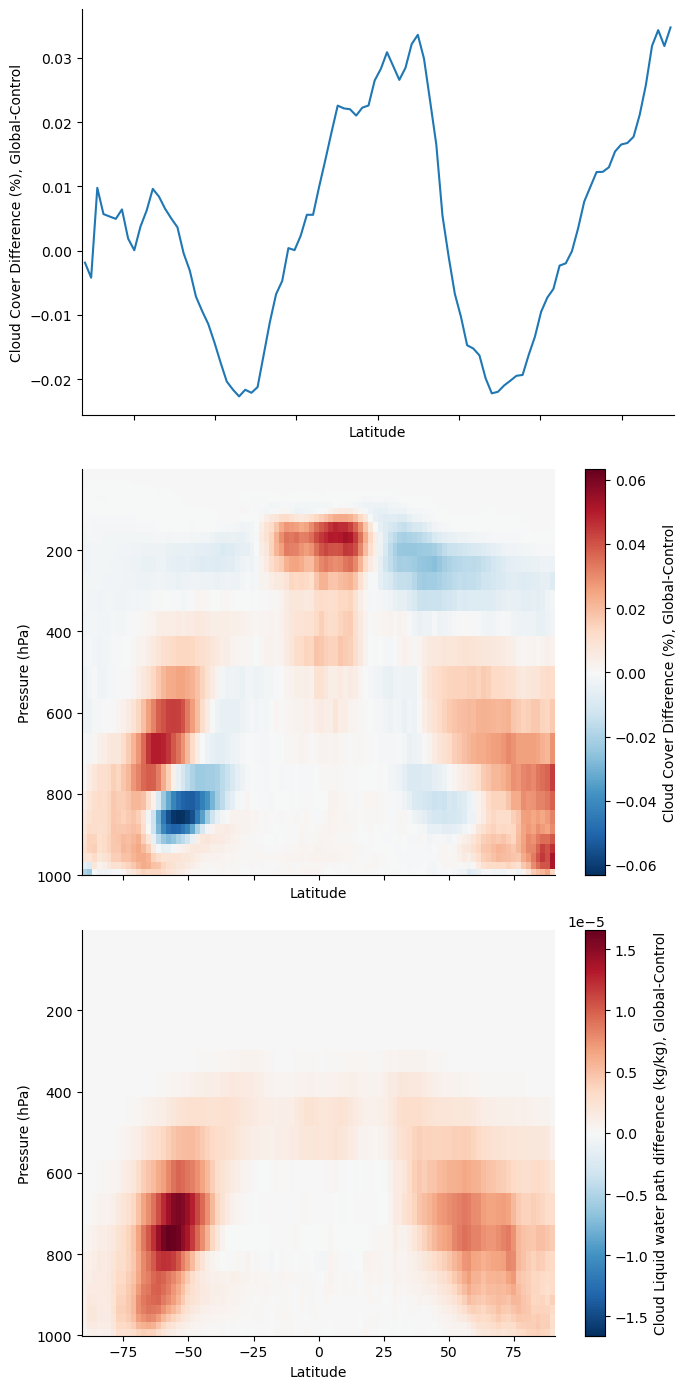

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,14), sharex='all')
diff = ds_dict['Global'] - ds_dict['CTRL']
diff['CLDTOT_mean_year_lon'].plot(ax=axs[0])
diff['CLOUD_mean_year_lon'].plot(ax=axs[1], cbar_kwargs={'label':'Cloud Cover Difference (%), Global-Control'})
diff['CLDLIQ_mean_year_lon'].plot(ax=axs[2], cbar_kwargs={'label' : 'Cloud Liquid water path difference (kg/kg), Global-Control'})
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_ylabel('Cloud Cover Difference (%), Global-Control')
axs[1].set_ylabel('Pressure (hPa)')
axs[2].set_ylabel('Pressure (hPa)')

axs[0].set_xlabel('Latitude')
axs[1].set_xlabel('Latitude')
axs[2].set_xlabel('Latitude')

sns.despine()
fig.tight_layout()

fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/nudged_clouds_CTRLvsGlobal.png')
fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/nudged_clouds_CTRLvsGlobal.pdf', format='PDF')